In [10]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.fftpack import fft
import math

import cv2

In [2]:
data, fs = sf.read("dolphinsound.wav")
ch1 = data[:,0]

In [4]:
start_time = (6*60+5)
end_time = (6*60+25)

fs = 96000

## stft parameters
fft_number = 1024
overlab = 0.5
window_type = 'hann'

# hydrophone spec, transfer the voltage data to pressure level
sensitivity = 211

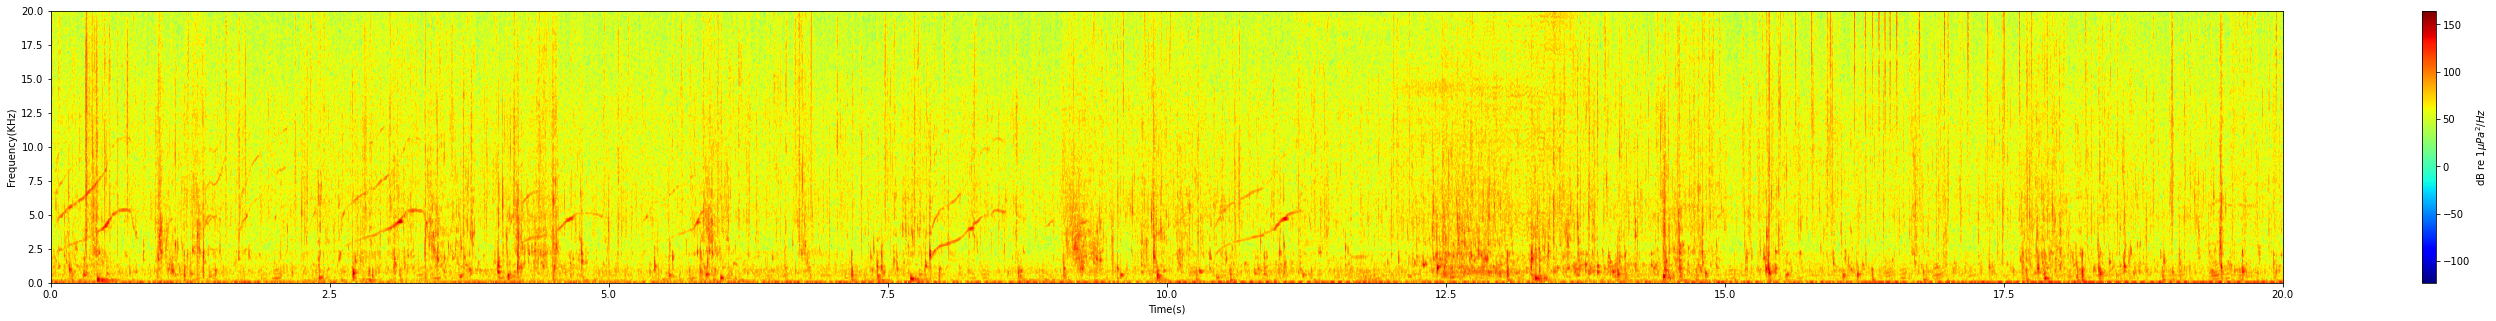

In [5]:
sample_time_series = ch1[fs*start_time:fs*end_time]
PSD = []

hop_size = math.ceil(fft_number*(1-overlab))

window = scipy.signal.get_window(window_type, fft_number, fftbins=True)

end_index = fft_number
half_size = math.ceil((fft_number+1)/2)
while(end_index<len(sample_time_series)):
    windowed_data = window*sample_time_series[end_index-fft_number:end_index]
    z = fft(windowed_data)[:half_size]/fft_number*2
    psd = 20*np.log10(abs(z)**2) + sensitivity
    PSD.append(psd)
    end_index += hop_size
PSD = np.array(PSD)

fig, ax = plt.subplots(figsize=(50,5))
im = ax.imshow(PSD.T, cmap='jet',  origin='lower', aspect='auto', 
               interpolation='hanning', extent=(0, 20, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

In [6]:
#################################################
# first step, click removal through time series #
#################################################

# parameters:
# 1. threshold
# 2. power

def removeClick(x):
    thresh = 5
    power = 6
    x = np.array(x*100)
    m = np.mean(x)
    SD = np.std(x)
    w = 1.0/(1+((x-m)/thresh*SD)**power)
    return w*x/100

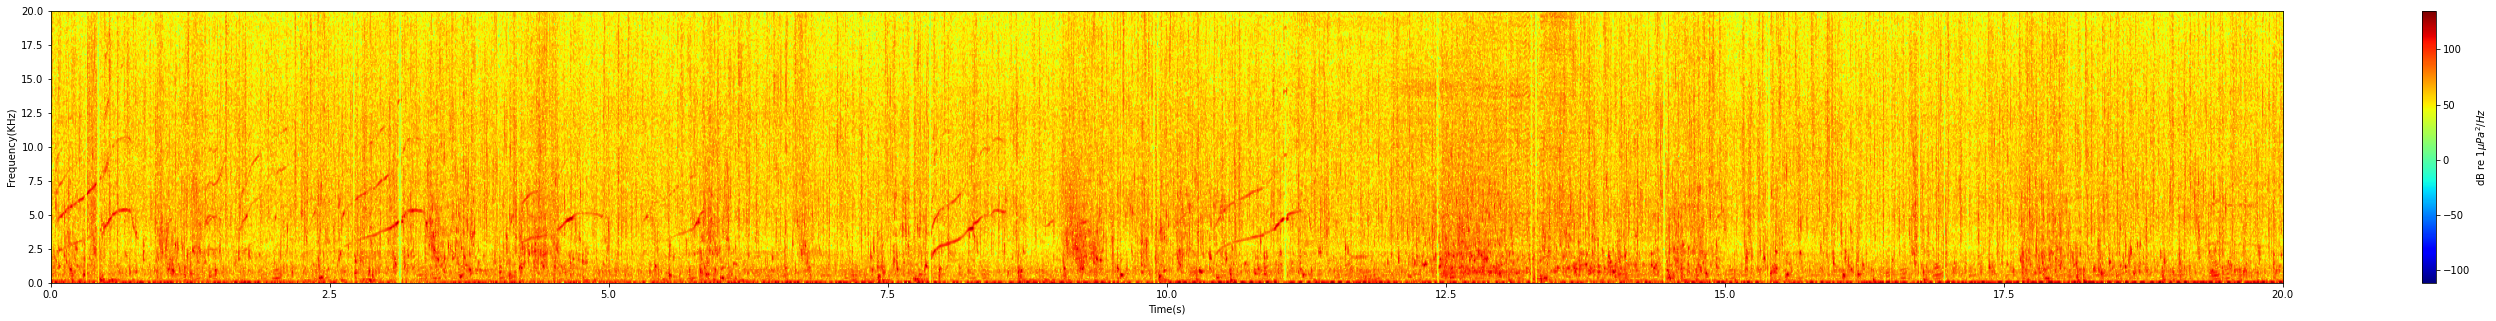

In [9]:
#############################
# Second step, STFT process #
#############################

# parameters:
# 1. fft_number
# 2. window_type
# 3. overlap ratio

sample_time_series = ch1[fs*start_time:fs*end_time]
PSD_clickRemoval = []

hop_size = math.ceil(fft_number*(1-overlab))

window = scipy.signal.get_window(window_type, fft_number, fftbins=True)

end_index = fft_number
half_size = math.ceil((fft_number+1)/2)
while(end_index<len(sample_time_series)):
    weighted_data = removeClick(sample_time_series[end_index-fft_number:end_index])
    windowed_data = window*weighted_data
    z = fft(windowed_data)[:half_size]/fft_number*2
    psd = 20*np.log10(abs(z)**2) + sensitivity
    PSD_clickRemoval.append(psd)
    end_index += hop_size
PSD_clickRemoval = np.array(PSD_clickRemoval)

fig, ax = plt.subplots(figsize=(50,5))
im = ax.imshow(PSD_clickRemoval.T, cmap='jet',  origin='lower', aspect='auto', 
               interpolation='hanning', extent=(0, 20, 0, fs//2/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
c_bar.set_label("dB re 1" + r'$\mu Pa^{2}/Hz$')
plt.show()

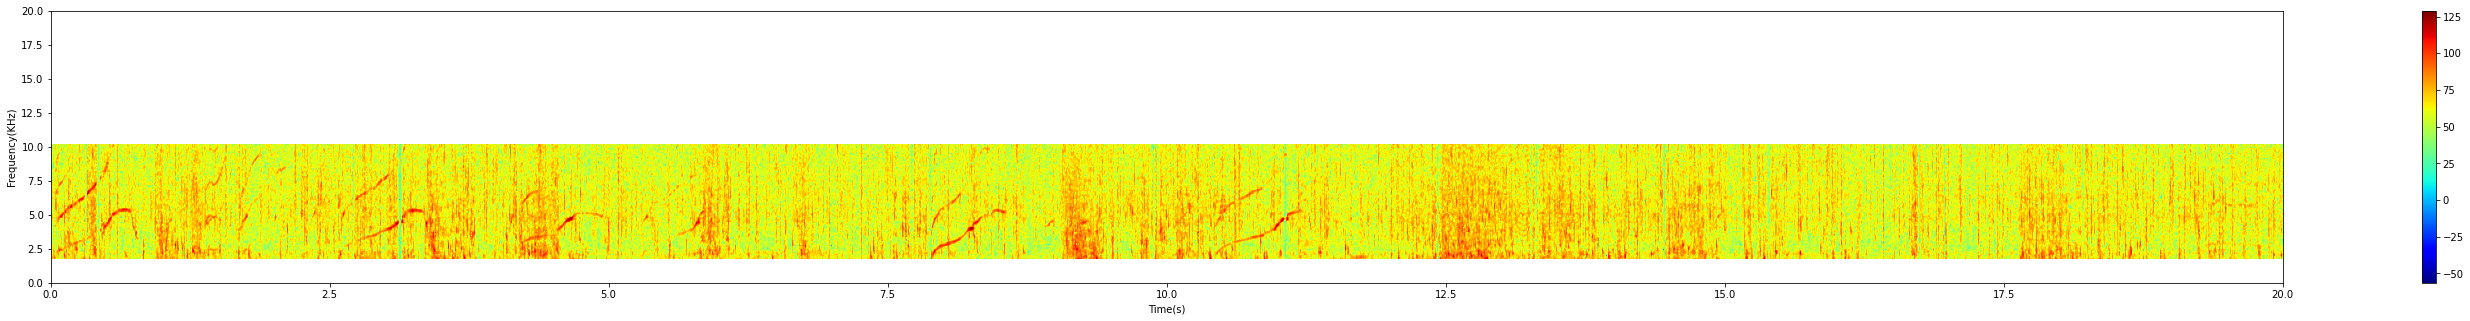

In [21]:
############################
# Third step, band passing #
############################

# parameters:
# 1. start freq
# 2. end freq
start_fre = 2000
end_fre = 10000

band_width = 300
width_size = math.ceil(band_width/2/df)


f = np.arange(half_size)*fs/fft_number
df = fs/fft_number
start_index = math.floor((start_fre)/df)-width_size
end_index = math.ceil((end_fre)/df)+width_size

band_pass = PSD_clickRemoval.T[start_index:end_index,:]

fig, ax = plt.subplots(figsize=(50,5))
im = ax.imshow(band_pass, cmap="jet", origin='lower', aspect='auto',
               interpolation=None, extent=(0, 20, f[start_index]/1000, f[end_index]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()

In [22]:
##############################
# Fourth step, image bluring #
##############################

# applying median bluring



median_blur = cv2.medianBlur(band_pass.astype(np.float32),3)

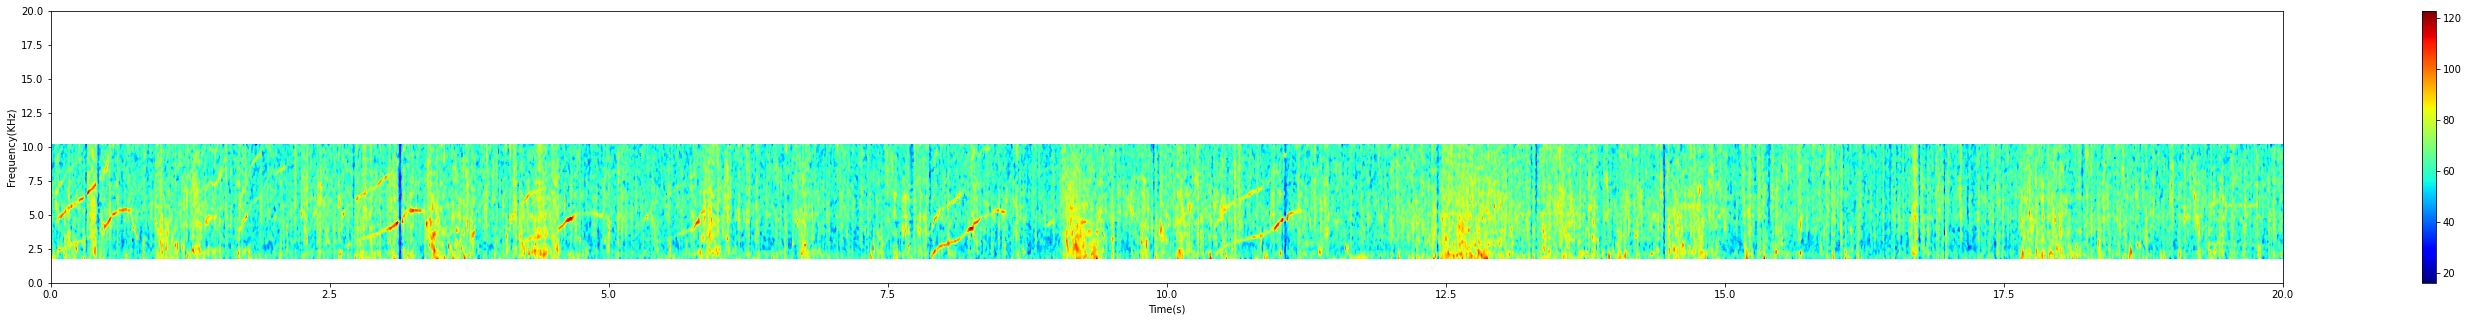

In [39]:
fig, ax = plt.subplots(figsize=(50,5))
im = ax.imshow(median_blur, cmap="jet", origin='lower', aspect='auto',
               interpolation=None, extent=(0, 20, f[start_index]/1000, f[end_index]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()

In [20]:
median_blur.shape[0]

86

In [37]:
###################################
# Fourth step, narrow band filter #
###################################

# take advantage of whistle features, narrow band width

# parameters:
# 1. band width
# 2. threshold

band_width = 300
threshold = 3

width_size = math.ceil(band_width/2/df)
start_index_change = width_size
end_index_change = -width_size

truefalsematrix = []
for i in range(median_blur.shape[1]):
    col = median_blur[:,i]
    p1 = col[start_index_change:end_index_change]
    median_p1 = []
    for j in range(end_index-start_index-2*width_size):
        median = np.median(col[j:j+(2*width_size)+1])
        median_p1.append(median)
    median_p1 = np.array(median_p1)
    SNR = 10*np.log10(p1/median_p1)
    truefalsematrix.append(SNR>threshold)
truefalsematrix = np.array(truefalsematrix)

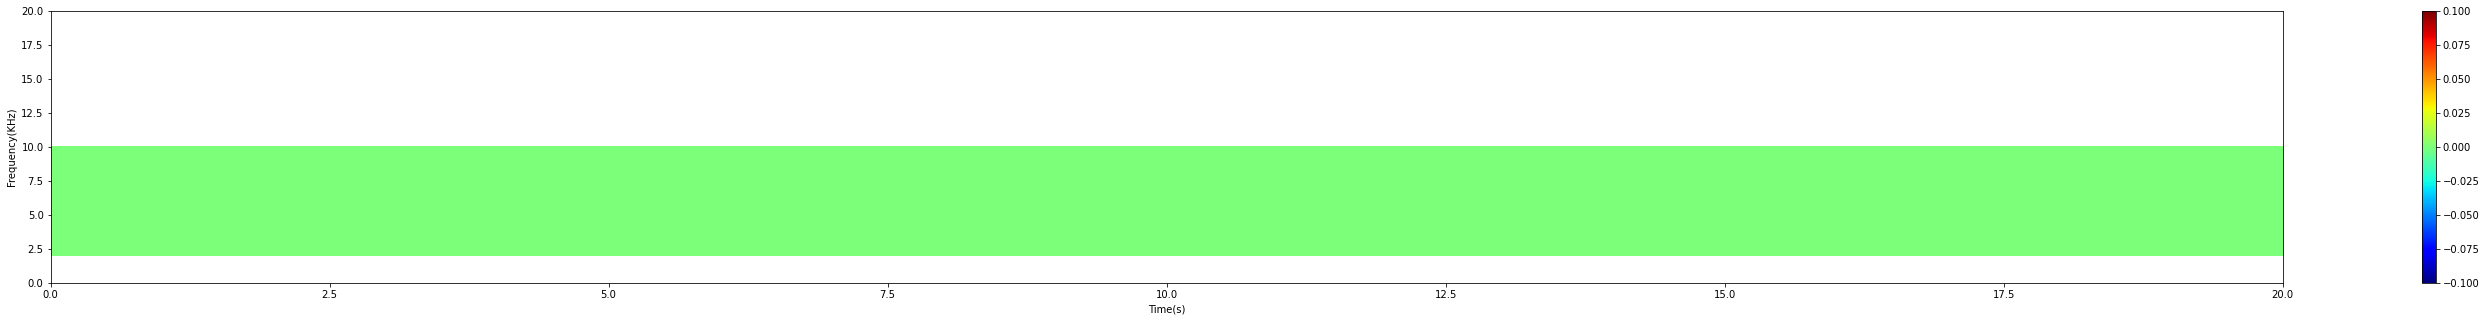

In [38]:
fig, ax = plt.subplots(figsize=(50,5))
im = ax.imshow(truefalsematrix, cmap="jet", origin='lower', aspect='auto',
               interpolation=None, extent=(0, 20, f[start_index+width_size]/1000, f[end_index-width_size]/1000))
ax.set_ylim([0,20])
ax.set_xlabel("Time(s)")
ax.set_ylabel("Frequency(KHz)")
c_bar = fig.colorbar(im)
plt.show()